In [52]:
from pathlib import Path
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt # for making figures
import numpy as np
import random
# from scipy import ndimage
from collections import OrderedDict
%matplotlib inline

total number of subjects: 480
(240, 240, 155) float64
(240, 240, 155) float64


[]

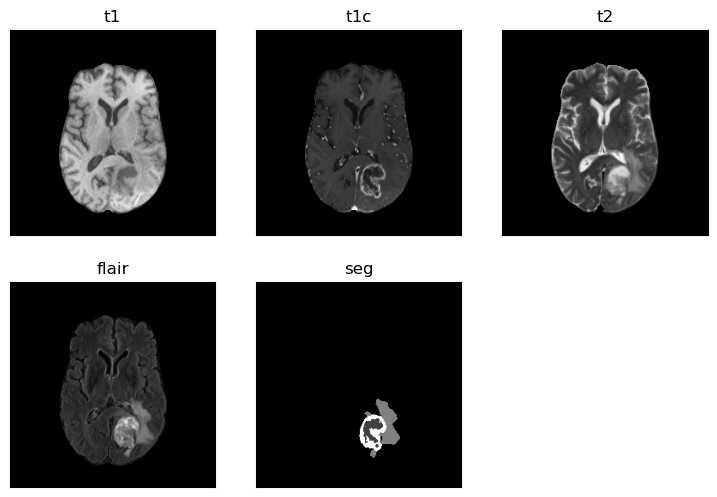

In [53]:
torch.manual_seed(42 + 2)
data_path = Path('../dataset')
subjects = [s for s in data_path.iterdir()]
print('total number of subjects: {}'.format(len(subjects)))
idx = torch.randint(0, len(subjects) - 1, (1, ))

# 4 modalities + segmentation
# Vamos fazer load de um único paciente, só para fazer pequenos testes
t1 = nib.load(list(subjects[idx].glob('*t1*'))[0]).get_fdata()
t1c = nib.load(list(subjects[idx].glob('*t1c*'))[0]).get_fdata()
t2 = nib.load(list(subjects[idx].glob('*t2*'))[0]).get_fdata()
flair = nib.load(list(subjects[idx].glob('*flair*'))[0]).get_fdata()
seg = nib.load(list(subjects[idx].glob('*seg*'))[0]).get_fdata()

print(t1.shape, t1.dtype)
print(seg.shape, seg.dtype)

# idx = torch.randint(0, t1.shape[-1] - 1, (1, ))
idx = 75

plt.figure(figsize=(9, 6))
plt.subplot(231)
plt.imshow(t1[..., idx].T, cmap='gray')
plt.title('t1')

plt.subplot(232)
plt.imshow(t1c[..., idx].T, cmap='gray')
plt.title('t1c')

plt.subplot(233)
plt.imshow(t2[..., idx].T, cmap='gray')
plt.title('t2')

plt.subplot(234)
plt.imshow(flair[..., idx].T, cmap='gray')
plt.title('flair')

plt.subplot(235)
plt.imshow(seg[..., idx].T, cmap='gray')
plt.title('seg')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

(4, 129, 181, 141)
(1, 129, 181, 141)


Text(0.5, 1.0, 'cropped')

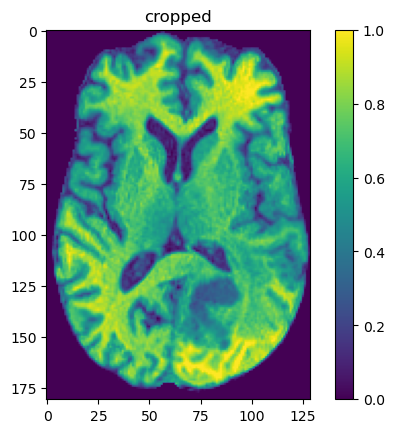

In [54]:
def pre_proc(img):
    p1, p99 = np.percentile(img[img != 0], [1, 99])
    # print(p1, p99)
    x = np.clip(img, p1, p99)
    # print(np.min(x), np.max(x))
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x

X = np.stack([pre_proc(img) for img in [t1, t1c, t2, flair]])
# Y = seg[None, :, :, :]
Y = seg
Y = Y[None, ...]

_, x_min, y_min, z_min = [np.min(idx) for idx in np.nonzero(X)]
_, x_max, y_max, z_max = [np.max(idx) for idx in np.nonzero(X)]

X = X[:, x_min:x_max, y_min:y_max, z_min:z_max]
Y = Y[:, x_min:x_max, y_min:y_max, z_min:z_max]

print(X.shape)
print(Y.shape)

plt.imshow(X[0, ..., 75].T)
plt.colorbar()
plt.title('cropped')

(4, 128, 128, 128)


Text(0.5, 1.0, 'cropped to 128 x 128')

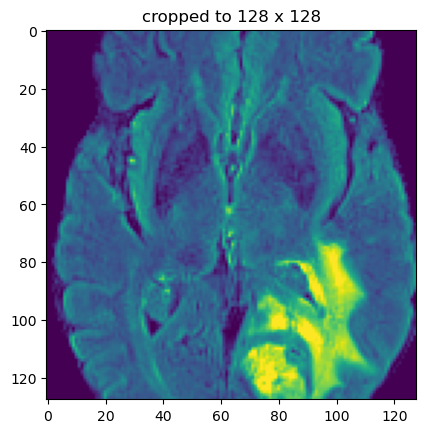

In [55]:
# no paper original https://arxiv.org/pdf/2011.01045.pdf
# eles no pre processamento fazem um crop random de cada paciente para um tamanho de 128x128x128
# para retirar a maioria do background na maioria das slices, aqui o crop não é random, apenas centrado
def crop128(vol):
    C, X, Y, Z = vol.shape
    x_start = (X - 128) // 2
    y_start = (Y - 128) // 2
    z_start = (Z - 128) // 2
    out = vol[:, x_start:x_start + 128, y_start:y_start + 128, z_start:z_start + 128]
    return out

X = crop128(X)
Y = crop128(Y)
print(X.shape)
plt.imshow(X[3, ..., 64].T)
plt.title('cropped to 128 x 128')

[16. 18. 20. 21. 23. 24. 26. 27. 27. 28. 29. 30. 30. 31. 31. 32. 32. 33.
 33. 34. 36. 38. 39. 41. 43. 45. 46. 48. 50. 53. 55. 58. 60. 62. 63. 64.
 65. 66. 66. 67. 68. 68. 69. 70. 72. 74. 76. 78. 79. 81. 82. 83. 84. 84.
 85. 86. 86. 87. 87. 87. 87. 87. 87. 87. 88. 88. 88. 88. 88. 88. 88. 88.
 88. 88. 88. 88. 89. 88. 88. 88. 88. 88. 88. 87. 87. 87. 86. 86. 86. 85.
 85. 84. 84. 83. 83. 82. 81. 80. 80. 79. 78. 77. 76. 75. 73. 72. 71. 69.
 68. 66. 65. 63. 61. 58. 56. 53. 51. 48. 45. 43. 40. 37. 34. 31. 28. 24.
 21. 18.]
(4, 128, 128, 89)
(1, 128, 128, 89)


[]

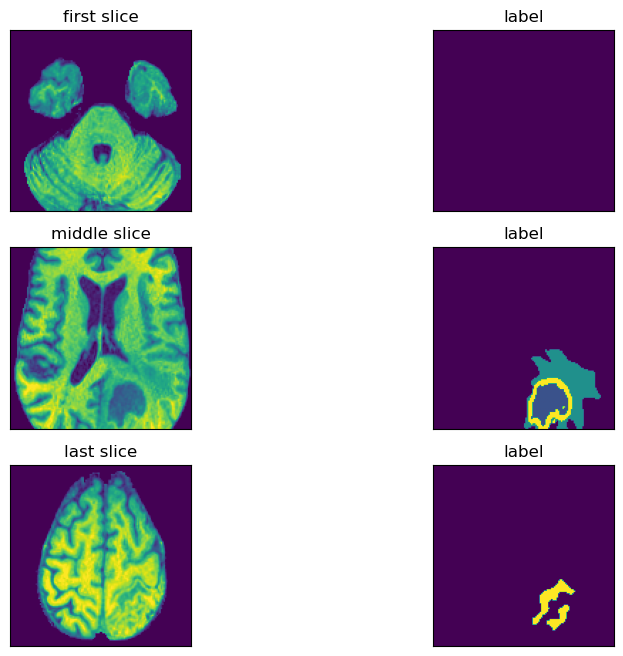

In [56]:
# remover as slices com demasiado background
counts_per_slice = np.count_nonzero(X[0, ...], axis=(0, 1))
n_pixels = np.size(X[0, ..., 0]) # per axial slice
pixel_density = np.floor(counts_per_slice / n_pixels * 100) # per axial slice
print(pixel_density)

T = 50 # threshold
X = X[..., pixel_density >= T]
Y = Y[..., pixel_density >= T]
print(X.shape)
print(Y.shape)

plt.figure(figsize=(10, 8))
plt.subplot(321)
plt.imshow(X[0, ..., 0].T)
plt.title('first slice')

plt.subplot(322)
plt.imshow(Y[0, ..., 0].T)
plt.title('label')

plt.subplot(323)
plt.imshow(X[0, ..., 50].T)
plt.title('middle slice')

plt.subplot(324)
plt.imshow(Y[0, ..., 50].T)
plt.title('label')

plt.subplot(325)
plt.imshow(X[0, ..., -1].T)
plt.title('last slice')

plt.subplot(326)
plt.imshow(Y[0, ..., -1].T)
plt.title('label')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

True
True
True
(3, 128, 128, 89)


Text(0.5, 1.0, 'WT')

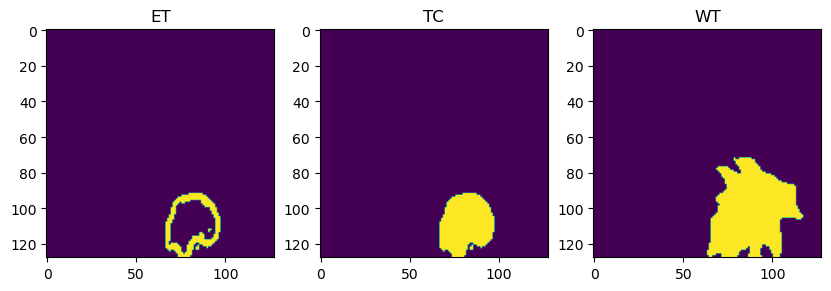

In [57]:
# mudar as labels para "region based", ver secção "Region based training" em https://arxiv.org/pdf/2011.00848.pdf
# segundo eles, isto melhora o treino

# De acordo com  https://www.med.upenn.edu/cbica/brats2020/data.html
# As labels originais são:
# label = 1 : NCR/NET (necrotic/non-enhancing tumour)
# label = 2 : ED (peritumoral edema)
# label = 4 : ET (GD-enhancing tumour)
# É preciso mudar as labels para:
# WT (whole tumour, união das 3 regiões)
# TC (tumour core, união entre ET e NCR/NET
# ET (enhancing tumour, igual à label = 4)

NCR_mask = Y == 1.0
ED_mask = Y == 2.0
ET_mask = Y == 4.0

print(NCR_mask.any())
print(ED_mask.any())
print(ET_mask.any())

WT_mask = NCR_mask + ED_mask + ET_mask
TC_mask = ET_mask + NCR_mask

Y = np.concatenate((ET_mask, TC_mask, WT_mask), axis=0, dtype=float)
print(Y.shape)

plt.figure(figsize=(10, 8))
plt.subplot(131)
plt.imshow(Y[0, ..., 50].T)
plt.title('ET')

plt.subplot(132)
plt.imshow(Y[1, ..., 50].T)
plt.title('TC')

plt.subplot(133)
plt.imshow(Y[2, ..., 50].T)
plt.title('WT')

In [58]:
# Touches finais ao dataset, aqui, para testar apenas, o dataset inteiro é o volume de um só paciente
# cada sample independente é uma slice axial desse paciente, ou seja, a última dimensão de X e Y é a
# nossa batch dimension, o pytorch espera tesnores na forma B x C x W x H, em que B = batch, C = channel, 
X = np.transpose(X, (3, 0, 1, 2))
Y = np.transpose(Y, (3, 0, 1, 2))
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

[70 60  2 29 83  4 39 28 52 18 40 27 26 38 50 24 33  0 42 86 73 61 51 17
  7 56 21 80 25 88 75 10 69  5 68  1 37 84 55 72 82 20 76 43 78 32 62 23
 85 57 15 59 45  9 31 63 81 16 44 48 46 67 71  3 34 30 58 87 54 49  6 79
 11 74 41 22 19 35 64 47 12 53 14 13 66 36 65 77  8]
torch.Size([71, 4, 128, 128])
torch.Size([9, 4, 128, 128])
torch.Size([9, 4, 128, 128])


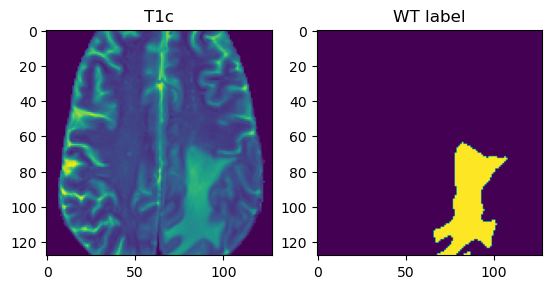

In [59]:
# falta fazer um shuffling do dataset e dividir em treino, validação e teste
rng = np.random.default_rng(seed=42)
shuffle = rng.permutation(X.shape[0])

print(shuffle)

n1 = int(0.8*len(shuffle))
n2 = int(0.9*len(shuffle))

Xtr = X[shuffle[:n1], ...]     # 80%
Xdev = X[shuffle[n1:n2], ...]  # 10%
Xte = X[shuffle[n2:], ...]     # 10%

Ytr = Y[shuffle[:n1], ...]     # 80%
Ydev = Y[shuffle[n1:n2], ...]  # 10%
Yte = Y[shuffle[n2:], ...]     # 10%

plt.subplot(121)
plt.imshow(Xtr[0, 2, ...].T)
plt.title('T1c')

plt.subplot(122)
plt.imshow(Ytr[0, 2, ...].T)
plt.title('WT label')

print(Xtr.shape)
print(Xdev.shape)
print(Xte.shape)

In [60]:
# Unet encoder
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_chs=1):
        super().__init__()
        self.block1 = DownBlock(in_chs, 48)
        self.block2 = DownBlock(48, 96)
        self.block3 = DownBlock(96, 192)
        self.block4 = DownBlock(192, 384)
        self.maxpool = nn.MaxPool2d(2, stride=2)
    
    def forward(self, x):
        feature_maps = []

        # if missing_mask is not None:
        #     missing_mask_tensor = torch.tensor(missing_mask, dtype=torch.float32, device=x.device).view(1, -1, 1, 1)
        #     x = x * missing_mask_tensor  # Apply mask to input
        
        feature_maps.append(x)
        
        x = self.block1(x)
        feature_maps.append(x)
        x = self.maxpool(x)

        x = self.block2(x)
        feature_maps.append(x)
        x = self.maxpool(x)

        x = self.block3(x)
        feature_maps.append(x)
        x = self.maxpool(x)

        x = self.block4(x)
        feature_maps.append(x)
        x = self.maxpool(x)

        # if missing_mask is not None:
        #     target_size = feature_maps[0].shape[-2:]  # Use the size of the first feature map
        #     resized_features = [F.interpolate(f, size=target_size, mode='bilinear', align_corners=False) for f in feature_maps]
        #     missing_mask_tensor = torch.tensor(missing_mask, dtype=torch.float32, device=x.device).view(1, -1, 1, 1)

        #     if teacher_idx is not None:
        #         missing_features = weighted_average(resized_features, missing_mask, teacher_idx)
        #         feature_maps.append(missing_features)
        #     else:
        #         present_features = [f * missing_mask_tensor[:, i:i+1, :, :] for i, f in enumerate(resized_features)]
        #         if len(present_features) > 0:
        #             # Compute the average of the present modalities
        #             missing_features = torch.mean(torch.stack(present_features), dim=0)
        #             feature_maps.append(missing_features)
        #         else:
        #             print("Warning: No modalities are present.") #This should never happen
        return feature_maps

encoder = Encoder()
x = torch.randn((1, 1, 240, 240))
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 1, 240, 240])
torch.Size([1, 48, 236, 236])
torch.Size([1, 96, 114, 114])
torch.Size([1, 192, 53, 53])
torch.Size([1, 384, 22, 22])


In [61]:
# retirado de https://discuss.pytorch.org/t/using-nn-function-interpolate-inside-nn-sequential/23588
# forma de criar uma "layer artificial" que faz o upsampling por meio de interpolção como no artigo "open brats 2020"
# acabei por não usar isto dentro do decoder
class Interpolate(nn.Module):
    def __init__(self, size):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode='bilinear', align_corners=False) # no código do artigo tem align_corners=True
        return x
interp = Interpolate(53)
x = ftrs[-1]
print(x.shape)
x = interp(x)
print(x.shape)

torch.Size([1, 384, 22, 22])
torch.Size([1, 384, 53, 53])


In [62]:
# Unet decoder
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        # print(type(in_chs // 2))
        # print(in_chs // 2)
        self.conv1 = nn.Conv2d(in_chs, in_chs // 2, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_chs // 2, out_chs, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_chs=1):
        super().__init__()
        self.block1 = nn.Conv2d(384 * 2, 192, 3)
        self.block2 = UpBlock(192 * 2, 96)
        self.block3 = UpBlock(96 * 2, 48)
        self.block4 = UpBlock(48 * 2, 48)
        self.last_conv = nn.Conv2d(48, out_chs, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, encoder_features):
        x = torch.cat((x, encoder_features[-1]), dim=1)
        x = self.block1(x)
        x = self.relu(x)
        x =  F.interpolate(x, size=encoder_features[-2].shape[-1], mode='bilinear', align_corners=True) # verificar o que siginifca align_corners

        x = torch.cat((encoder_features[-2], x), dim=1)

        x = self.block2(x)
        x = self.relu(x)
        x =  F.interpolate(x, size=encoder_features[-3].shape[-1], mode='bilinear', align_corners=True)

        x = torch.cat((encoder_features[-3], x), dim=1)
        x = self.block3(x)
        x = self.relu(x)
        x =  F.interpolate(x, size=encoder_features[-4].shape[-1], mode='bilinear', align_corners=True)

        x = torch.cat((encoder_features[-4], x), dim=1)
        x = self.block4(x)
        x = self.relu(x)
        x =  F.interpolate(x, size=encoder_features[-5].shape[-1], mode='bilinear', align_corners=True)
        x = self.last_conv(x)
        x = self.sigmoid(x)

        return x


decoder = Decoder()
x = torch.randn(1, 384, 22, 22)
out = decoder(x, ftrs)
print(out.shape)
# decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 1, 240, 240])


In [63]:
# Unet para o BraTS como descrita em https://arxiv.org/pdf/2011.01045.pdf (espero eu)
# só que aqui é aplicada a imagens 2D em vez de volumes 3D
# o código original do artigo pode ser encontrado aqui https://github.com/lescientifik/open_brats2020
# mas a implementação lá é mais complexa, com mais etapas de pre processamento e data augmentation

class BratsUnet(nn.Module):
    def __init__(self, in_chs=1, num_classes=1):
        super().__init__()
        self.encoder = Encoder(in_chs=in_chs)
        self.decoder = Decoder(out_chs=num_classes)
        self.dilated_conv1 = nn.Conv2d(384, 384, 3, dilation=2, padding=2) # padding = 2 detalhe importante retirado do código do artigo
        self.dilated_conv2 = nn.Conv2d(384, 384, 3, dilation=2, padding=2) # não mencionado no próprio artigo
        self.relu = nn.ReLU()

    def forward(self, x, missing_mask=None, teacher_idx=None):
        ftrs = self.encoder(x)
        x_dil = self.dilated_conv1(ftrs[-1])
        x_dil = self.relu(x_dil)
        x_dil = self.dilated_conv2(x_dil)
        x_dil = self.relu(x_dil)
        # print(x_dil.shape)
        # print(ftrs[-1].shape)
        x = self.decoder(x_dil, ftrs)
        return x

# x = vol[None, None, ..., idx]
x = torch.randn((1, 4, 240, 240))
model = BratsUnet(in_chs=4, num_classes=3)  # 4 image modalities and Gt label with 3 possible classes
y = model(x)
print(y.shape)
print('total parameters: {}'.format(sum(p.numel() for p in model.parameters())))

torch.Size([1, 3, 240, 240])
total parameters: 7718595


In [64]:
def teacher_election(model, X_val, Y_val):
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for modality in range(X_val.shape[1]):
            X_mod = torch.zeros_like(X_val)
            X_mod[:, modality:modality+1, :, :] = X_val[:, modality:modality+1, :, :]
            logits = model(X_mod)
            dice = dice_loss(logits, Y_val)
            dice_scores.append(dice.item())
    best_modality = np.argmin(dice_scores)
    model.train()
    return best_modality


In [65]:
def cross_modal_knowledge_distillation_loss(ftrs_teacher, ftrs_student):
    loss = 0
    for ft, fs in zip(ftrs_teacher, ftrs_student):
        loss += torch.nn.functional.l1_loss(fs, ft)
    return loss

In [66]:
def get_missing_mask(step, max_steps, modalities=4):
    # Progressive probability decrease from 0.9 to 0.1 over the course of training
    prob = 0.9 - 0.8 * (step / max_steps)
    
    # Generate a mask with 1 (present) and 0 (missing)
    missing_mask = [1 if torch.rand(1).item() < prob else 0 for _ in range(modalities)]
    
    # Ensure at least one modality is present
    if sum(missing_mask) == 0:  # If all modalities are missing, select one randomly to be present
        random_modality = random.randint(0, modalities - 1)
        missing_mask[random_modality] = 1  # Set one modality to present
    
    return missing_mask

In [67]:
def weighted_average(feature_maps, missing_mask, teacher_idx):
    weighted_sum = 0.0
    weight_sum = 0.0

    teacher_weight=2.0
    
    # Accumulate weighted features and their corresponding weights
    for idx, (f, m) in enumerate(zip(feature_maps, missing_mask)):
        if not m:  
            if idx == teacher_idx:
                weighted_sum += f * teacher_weight
                weight_sum += teacher_weight
            else:
                weighted_sum += f  
                weight_sum += 1.0

    # Normalize by the sum of the weights
    return weighted_sum / weight_sum

In [68]:
# Dice loss
def dice_loss(S, R, epsilon=1):
    intersect = 2 * (S*R).sum((-1, -2)) + epsilon # na expressão do artigo, não multiplica por 2, mas no código git sim
    union = S.pow(2).sum((-1, -2)) + R.pow(2).sum((-1, 2)) + epsilon
    out = (intersect / union).sum(1) / R.shape[1]
    return (1 - out).mean(0)

s = torch.randn((1, 3, 128, 128))
r = torch.randn((1, 3, 128, 128))
dice = dice_loss(s, s, epsilon=0) # confirmar que a dice loss entre 2 arrays iguais é 0
print(dice)

tensor(0.)


In [69]:
# loop de treino
g = torch.Generator().manual_seed(2147483647)
max_steps = 1000
batch_size = 32
lossi = []
ud = []
alpha = 0.05

modalities = ['T1', 'T1c', 'T2', 'Flair']

# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda:0':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# Xtr.to(device)
# Ytr.to(device)
model = BratsUnet(in_chs=4, num_classes=3)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.1)

for i in range(max_steps):
  # missing_mask = get_missing_mask(i, max_steps)
  # print("MISSING MODALITY MASK: ", missing_mask)
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  Xb = Xb.cuda() # fazer Xb = Xb.to(device) como na expressão do model não funciona não sei porquê, dá erro
  Yb = Yb.cuda() # como está agora, faz com que este código não funcione para quem não tem gpu com cuda...

  #convert missing modalities mask to a tensor  
  # missing_tensor = torch.tensor(missing_mask, dtype=torch.float32, device=device).view(1, -1, 1, 1)
  # masked_Xb = Xb * missing_tensor
    
  # Perform teacher election
  if i % 500 == 0:
    best_modality = teacher_election(model, Xb, Yb)
    print("BEST MODALITY: ", modalities[best_modality])

  teacher_input = torch.zeros_like(Xb)
  teacher_input[:, best_modality:best_modality+1, :, :] = Xb[:, best_modality:best_modality+1, :, :]

  # forward pass
  optimizer.zero_grad()
    
  #FOR KD
  teacher_outputs = model(teacher_input)
  student_outputs = model(Xb) #([32, 3, 128, 128])

  teacher_features = model.encoder(teacher_input)
  student_features = model.encoder(Xb)
        
  # kd_loss = nn.KLDivLoss()(F.log_softmax(student_outputs, dim=1), F.softmax(teacher_outputs, dim=1))

  ckd_loss = 0
  # for t_feat, s_feat in zip(teacher_features, student_features):
  #   ckd_loss += torch.nn.functional.l1_loss(s_feat, t_feat)
  ckd_loss = cross_modal_knowledge_distillation_loss(teacher_features, student_features)

  #in the autoencoder should we generate features based on the teacher or all modalities?

  loss = dice_loss(student_outputs, Yb) # loss function
  
  combined_loss = (1 - alpha) * loss + alpha * ckd_loss
  # backward pass
  combined_loss.backward()
      
  # update
  optimizer.step()
  scheduler.step()
  # lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  # for p in model.parameters():
  #   p.data += -lr * p.grad

  # track stats
  if i % 10 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {combined_loss.item():.4f}')
  lossi.append(combined_loss.item())
  # with torch.no_grad():
  #   ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])

  # if i >= 10:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

Using device: cuda:0

BEST MODALITY:  Flair
      0/   1000: 0.8478
     10/   1000: 0.8579
     20/   1000: 0.8886
     30/   1000: 0.8842
     40/   1000: 0.7865
     50/   1000: 0.7382
     60/   1000: 0.6372
     70/   1000: 0.5846
     80/   1000: 0.5839
     90/   1000: 0.4340
    100/   1000: 0.6070
    110/   1000: 0.5646
    120/   1000: 0.3102
    130/   1000: 0.3344
    140/   1000: 0.2350
    150/   1000: 0.1928
    160/   1000: 0.1537
    170/   1000: 0.1608
    180/   1000: 0.1734
    190/   1000: 0.1408
    200/   1000: 0.1897
    210/   1000: 0.1476
    220/   1000: 0.1389
    230/   1000: 0.1956
    240/   1000: 0.1645
    250/   1000: 0.1259
    260/   1000: 0.1813
    270/   1000: 0.1341
    280/   1000: 0.1900
    290/   1000: 0.1322
    300/   1000: 0.1582
    310/   1000: 0.1244
    320/   1000: 0.2015
    330/   1000: 0.1091
    340/   1000: 0.1045
    350/   1000: 0.0824
    360/   1000: 0.1095
    370/   1000: 0.1226
    380/   1000: 0.1141
    390/   1000: 0.1

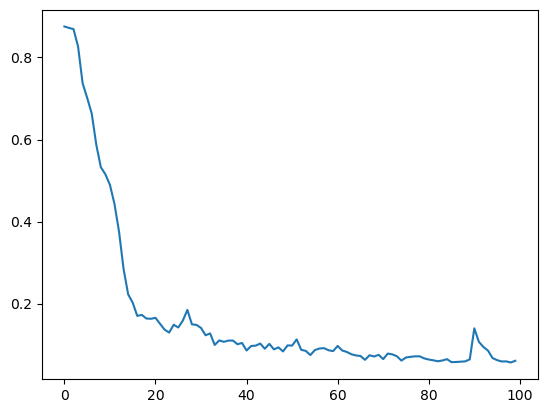

In [70]:
plt.plot(torch.tensor(lossi).view(-1, 10).mean(1))

In [71]:
# snippet taken from https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part5_cnn1.ipynb
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  model.eval()
  model.cpu()
  logits = model(x)
  loss = dice_loss(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.057313691824674606
val 0.06502089649438858


torch.Size([9, 3, 128, 128])


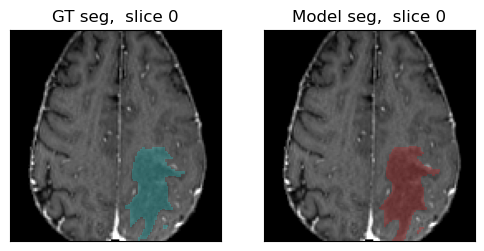

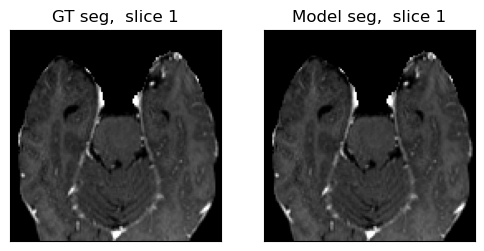

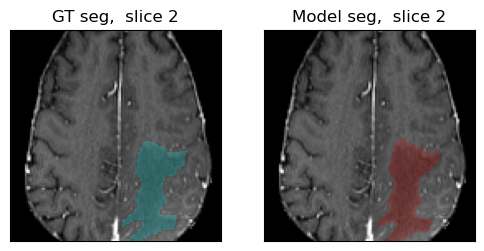

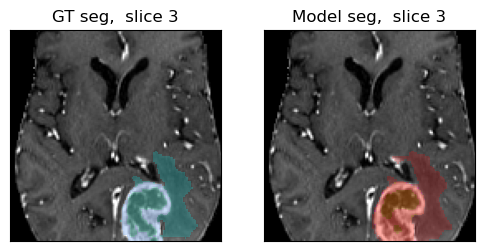

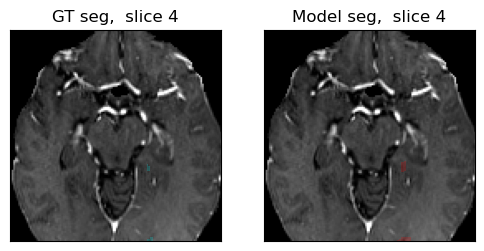

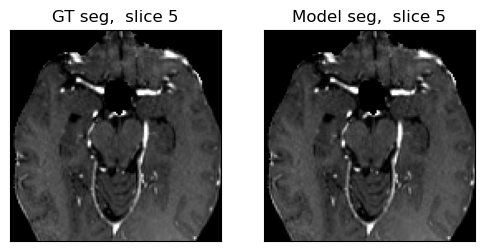

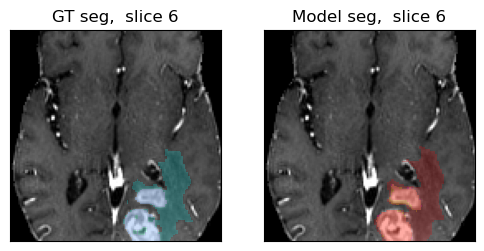

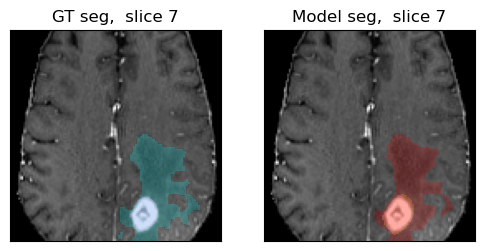

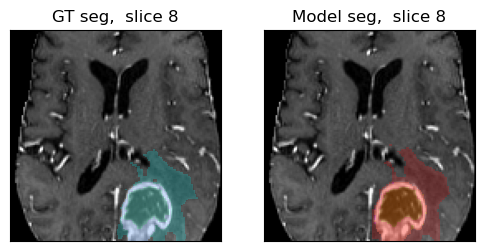

In [72]:
# Qualitative assessment on validation set
with torch.no_grad():
    model.eval
    logits = model(Xdev)

print(logits.shape)

segs = logits.cpu().detach().numpy()
gt = Ydev.cpu().detach().numpy()
imgs = Xdev.cpu().detach().numpy()

segs[segs < 0.5] = 0
segs[segs >= 0.5] = 1

ET_seg = segs[:, 0, ...]
TC_seg = segs[:, 1, ...]
WT_seg = segs[:, 2, ...]

ET_gt = gt[:, 0, ...]
TC_gt = gt[:, 1, ...]
WT_gt = gt[:, 2, ...]

idx = 6
for idx in range(imgs.shape[0]):
    
    plt.figure(figsize=(6, 4))
    plt.subplot(121)
    plt.imshow(imgs[idx, 1, :, :].T, cmap='gray')
    plt.imshow(np.ma.masked_where(ET_gt[idx, ...].T == False, ET_gt[idx, ...].T), cmap='cool_r', alpha=0.2)
    plt.imshow(np.ma.masked_where(TC_gt[idx, ...].T == False, TC_gt[idx, ...].T), cmap='YlGnBu', alpha=0.2)
    plt.imshow(np.ma.masked_where(WT_gt[idx, ...].T == False, WT_gt[idx, ...].T), cmap='cool', alpha=0.2)
    plt.title('GT seg,  slice {}'.format(idx))
    
    plt.subplot(122)
    plt.imshow(imgs[idx, 1, :, :].T, cmap='gray')
    plt.imshow(np.ma.masked_where(ET_seg[idx, ...].T == False, ET_seg[idx, ...].T), cmap='cool_r', alpha=0.2)
    plt.imshow(np.ma.masked_where(TC_seg[idx, ...].T == False, TC_seg[idx, ...].T), cmap='autumn_r', alpha=0.2)
    plt.imshow(np.ma.masked_where(WT_seg[idx, ...].T == False, WT_seg[idx, ...].T), cmap='autumn', alpha=0.2)
    plt.title('Model seg,  slice {}'.format(idx))
    
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])